## Capstone- Cancer Histopathology: Data Preprocessing

Dataset:
- A. Borkowski, "Lung and Colon Cancer Histopathological Images", Kaggle.com, 2020. [Online]. Available: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images. [Accessed: 30- Jul- 2022].

Sources:
- Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

Image Labels:
- Lung benign tissue: 3
- Lung adenocarcinoma: 2
- Lung squamous cell carcinoma: 4
- Colon adenocarcinoma: 0
- Colon benign tissue: 1

### Import Libraries

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
from pathlib import Path
import time
import math

# import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Data

In [2]:
import PIL
from PIL import Image
import glob
import cv2
import os, os.path
from numpy import asarray

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from IPython.display import display, HTML
import pymongo
from pymongo import MongoClient
import io
from bson.binary import Binary

### Data Preprocessing

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
%%time
data_dir = "./lung_colon_image_set/lung_image_sets"

# 80-20 Split
# data = ImageDataGenerator(validation_split = 0.3, rescale= 1.0/ 255.0)
data = ImageDataGenerator(rescale= 1./ 255.0)

BATCH_SIZE = 25000

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
X = Y = 96

train_ds = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

# validation = data.flow_from_directory(data_dir,
#                                       class_mode = "categorical",
#                                       target_size = (X, Y),
#                                       color_mode="rgb",
#                                       batch_size = BATCH_SIZE, 
#                                       shuffle = False,
#                                       subset='validation',
#                                       seed = 42)
X, y= train_ds.next()

Found 25000 images belonging to 5 classes.
CPU times: total: 1min 38s
Wall time: 2min 39s


In [5]:
train_ds.filenames[0]

'colon_aca\\colonca1.jpeg'

In [6]:
# sqzeShape= np.squeeze(train_ds[0][0], axis=0)

In [7]:
# sqzeShape.shape

In [8]:
%%time
genDataArr= []
for i, j in zip(X, y):
    tupleGrp= (i, j)
    genDataArr.append(tupleGrp)

CPU times: total: 15.6 ms
Wall time: 17 ms


In [9]:
# np.save('genData96.npy', data)

In [10]:
# genData96= np.load('genData96.npy', allow_pickle= True)

In [11]:
%%time
dfGenData= pd.DataFrame(genDataArr, columns=['imageVector', 'label'])
dfGenData.head()

CPU times: total: 0 ns
Wall time: 9.97 ms


,imageVector,label
0,"[[[0.9803922, 0.8078432, 0.91372555], [0.93333...","[1.0, 0.0, 0.0, 0.0, 0.0]"
1,"[[[0.882353, 0.7372549, 0.9490197], [0.8588236...","[1.0, 0.0, 0.0, 0.0, 0.0]"
2,"[[[0.9960785, 1.0, 0.9803922], [0.9960785, 1.0...","[1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[[[0.94117653, 0.90196085, 0.9058824], [0.9372...","[1.0, 0.0, 0.0, 0.0, 0.0]"
4,"[[[0.9843138, 0.5372549, 0.7725491], [0.972549...","[1.0, 0.0, 0.0, 0.0, 0.0]"


In [12]:
%%time
imgVectData= np.array(dfGenData['imageVector'].tolist())
imgVectData.shape

CPU times: total: 1.3 s
Wall time: 1.37 s


(25000, 96, 96, 3)

In [13]:
labelData= np.array(dfGenData['label'].tolist())
labelData.shape

(25000, 5)

In [14]:
dfGenData['label'][0]

array([1., 0., 0., 0., 0.], dtype=float32)

In [15]:
def normalizeImage(image):
    imgVect= image/ 255.0
    return imgVect

In [16]:
def imageFromArray(imgFile):
    data= array_to_img(imgFile)
    return data

In [17]:
def convertToClasses(label):
    classLabel= np.argmax(label, axis=None, out=None)
    return classLabel

In [18]:
def assignLabelTag(cell):
    if cell == 0:
        labelTag= 'colon_aca'
    elif cell == 1:
        labelTag= 'colon_n'
    elif cell == 2:
        labelTag= 'lung_aca'
    elif cell == 3:
        labelTag= 'lung_n'
    else:
        labelTag= 'lung_scc'
    return labelTag

In [19]:
# y_classes= [np.argmax(y, axis=None, out=None) for y in y]

In [20]:
dfGenData['classLabel']= dfGenData['label'].apply(convertToClasses)
dfGenData['image']= dfGenData['imageVector'].apply(lambda x: imageFromArray(x))

In [21]:
dfGenData['labelName']= dfGenData['classLabel'].apply(lambda x: assignLabelTag(x))

In [22]:
dfGenData.sample(10)

,imageVector,label,classLabel,image,labelName
19007,"[[[0.8431373, 0.7803922, 0.7803922], [0.843137...","[0.0, 0.0, 0.0, 1.0, 0.0]",3,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_n
1549,"[[[0.6666667, 0.654902, 0.9333334], [0.5921569...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca
20378,"[[[0.7019608, 0.6431373, 0.9607844], [0.678431...","[0.0, 0.0, 0.0, 0.0, 1.0]",4,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_scc
11331,"[[[0.68235296, 0.54509807, 0.8745099], [0.6980...","[0.0, 0.0, 1.0, 0.0, 0.0]",2,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_aca
22092,"[[[0.53333336, 0.45098042, 0.86274517], [0.556...","[0.0, 0.0, 0.0, 0.0, 1.0]",4,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_scc
11051,"[[[0.627451, 0.47450984, 0.8235295], [0.658823...","[0.0, 0.0, 1.0, 0.0, 0.0]",2,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_aca
8988,"[[[0.9176471, 0.8941177, 0.9333334], [0.941176...","[0.0, 1.0, 0.0, 0.0, 0.0]",1,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_n
20130,"[[[0.43529415, 0.36078432, 0.7803922], [0.5921...","[0.0, 0.0, 0.0, 0.0, 1.0]",4,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_scc
6264,"[[[0.89019614, 0.72156864, 0.8980393], [0.7137...","[0.0, 1.0, 0.0, 0.0, 0.0]",1,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_n
2160,"[[[0.5137255, 0.4039216, 0.8470589], [0.564705...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca


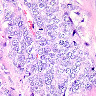

In [23]:
dfGenData['image'][0]

In [24]:
%%time
dfData= dfGenData.sample(frac=1).reset_index(drop= True)
dfData.sample(10)

CPU times: total: 15.6 ms
Wall time: 10.9 ms


,imageVector,label,classLabel,image,labelName
3162,"[[[0.6039216, 0.43921572, 0.86274517], [0.5882...","[0.0, 1.0, 0.0, 0.0, 0.0]",1,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_n
2424,"[[[0.5803922, 0.43137258, 0.654902], [0.619607...","[0.0, 0.0, 0.0, 1.0, 0.0]",3,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_n
15141,"[[[0.7058824, 0.64705884, 0.909804], [0.929411...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca
13116,"[[[0.69803923, 0.69411767, 0.9294118], [0.6392...","[0.0, 0.0, 1.0, 0.0, 0.0]",2,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_aca
21081,"[[[0.5176471, 0.31764707, 0.81568635], [0.5450...","[0.0, 1.0, 0.0, 0.0, 0.0]",1,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_n
21897,"[[[0.8078432, 0.6784314, 0.90196085], [0.77647...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca
19382,"[[[0.8705883, 0.8352942, 0.9176471], [0.858823...","[0.0, 0.0, 1.0, 0.0, 0.0]",2,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_aca
17062,"[[[0.6784314, 0.7686275, 0.94117653], [0.68627...","[0.0, 0.0, 1.0, 0.0, 0.0]",2,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_aca
19547,"[[[0.62352943, 0.49803925, 0.92549026], [0.572...","[0.0, 0.0, 0.0, 0.0, 1.0]",4,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_scc
22512,"[[[0.9843138, 0.96470594, 0.95294124], [0.9921...","[0.0, 1.0, 0.0, 0.0, 0.0]",1,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_n


In [25]:
dfArr= []
for i in dfData.values:
    dfArr.append(i)

In [26]:
np.save('shufGenData96.npy', dfArr)

In [27]:
%%time
dfShuffledData= pd.DataFrame(np.load('shufGenData96.npy', allow_pickle= True),
                             columns=['imageVector', 'label', 'classLabel', 'image', 'labelName'])
dfShuffledData.head()

CPU times: total: 7.47 s
Wall time: 49.5 s


,imageVector,label,classLabel,image,labelName
0,"[[[0.9960785, 0.98823535, 0.9921569], [0.98823...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca
1,"[[[0.98823535, 0.97647065, 0.9568628], [0.8470...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca
2,"[[[0.79215693, 0.6745098, 0.96470594], [0.7647...","[0.0, 0.0, 1.0, 0.0, 0.0]",2,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_aca
3,"[[[0.83921576, 0.5647059, 0.7686275], [0.85882...","[0.0, 0.0, 0.0, 1.0, 0.0]",3,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_n
4,"[[[0.40000004, 0.21176472, 0.7411765], [0.1647...","[0.0, 0.0, 0.0, 0.0, 1.0]",4,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_scc


In [28]:
dfShuffledData['classLabel'].value_counts()

0    5000
2    5000
3    5000
4    5000
1    5000
Name: classLabel, dtype: int64

In [29]:
%%time
imgVectData01= np.array(dfShuffledData['imageVector'].tolist())
imgVectData01.shape

CPU times: total: 984 ms
Wall time: 1.03 s


(25000, 96, 96, 3)

In [30]:
labelData01= np.array(dfShuffledData['label'].tolist())
labelData01.shape

(25000, 5)